# UNav Navigation Pipeline Visualization

This notebook demonstrates the end-to-end UNav navigation workflow: from loading the annotated floorplans, sampling start/destination, to planning and visualizing multi-floor navigation paths and generating spoken-style navigation commands.

## 1. Import Required Libraries and Visualization Tools

Import the necessary Python standard libraries, UNav config and navigation modules, and custom visualization functions for navigation and floorplan display.

In [7]:
import os
import math
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from unav.visualization_tools.navigation_visualization_tools import (
    sample_random_pose, perturb_pose_off_walkable_pose,
    plot_floorplan, plot_points, plot_pose, draw_graph_on_floorplans, plot_navigation_path
)
from unav.config import UNavConfig
from unav.navigator.commander import commands_from_result
from unav.navigator.multifloor import FacilityNavigator

## 2. Load Floorplan Data and Initialize FacilityNavigator

Set up experiment parameters, load all floorplan annotation files, and build the multi-floor navigation graph.

[✓] YAML written to: /mnt/data/UNav-IO/temp/equirectangular.yaml.


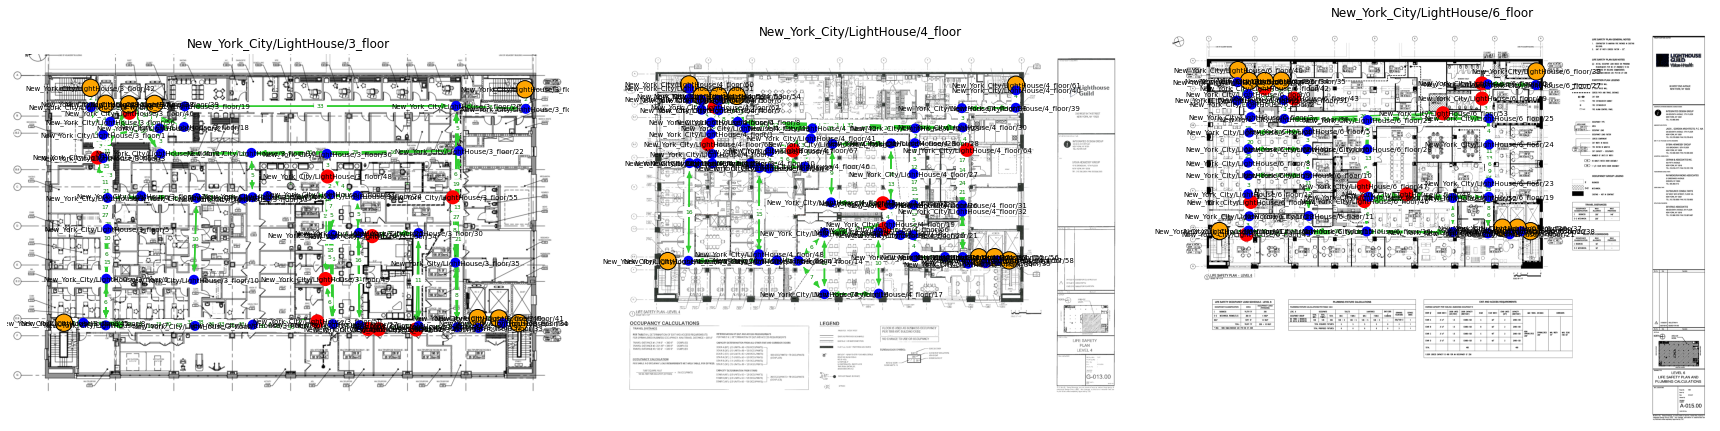

In [8]:
DATA_FINAL_ROOT = "/mnt/data/UNav-IO/data"
PLACES = {
    "New_York_City": {
        "LightHouse": ["3_floor", "4_floor", "6_floor"]
    }
}

config = UNavConfig(
    data_final_root=DATA_FINAL_ROOT,
    places=PLACES
)

nav = FacilityNavigator(config.navigator_config)

# === Automatically construct floor_keys from PLACES as tuple (place, building, floor) ===
floor_keys = [
    (place, building, floor)
    for place, building_dict in PLACES.items()
    for building, floors in building_dict.items()
    for floor in floors
]

# Visualize the unified navigation graph over all floorplans
draw_graph_on_floorplans(
    nav.G,
    pf_map=nav.pf_map,
    data_root=DATA_FINAL_ROOT,
    floor_keys=floor_keys,   # Tuple format keys: (place, building, floor)
    show_virt=False
)


## 3. Select Destination on a Target Floor

Choose the target place, building, and floor. List all possible destination points and allow for destination selection by index.

In [9]:
target_place = "New_York_City"
target_building = "LightHouse"
target_floor = "6_floor"
target_key = (target_place, target_building, target_floor)  # Use tuple as key

pf_target = nav.pf_map[target_key]

# Collect all available destination points for the target floor
destinations = [
    (pf_target.nodes[did], pf_target.labels[did])
    for did in pf_target.dest_ids
]

print(f"Available Destinations in {target_building} - {target_floor}:")
for i, (pt, name) in enumerate(destinations):
    print(f"[{i}] {name}")  # List each destination label with its index

Available Destinations in LightHouse - 6_floor:
[0] main elevator
[1] reception
[2] pantry 1
[3] Dr. Seiple's Office
[4] pantry 2
[5] ADA restroom
[6] board room
[7] men's restroom
[8] women's restroom
[9] backup elevator
[10] water heater room


## 4. Select the Destination and Sample a Random Starting Pose

Select the desired destination by index, and randomly sample a valid starting pose (across all mapped floors). Optionally, you can perturb the pose to test edge cases near the boundary.

In [10]:
selected_index = 3  # Change this to try different destinations
selected_pt, selected_name = destinations[selected_index]
print(f"Selected destination: {selected_name} on {target_floor} of {target_building}")

key, (x, y), theta = sample_random_pose(nav.pf_map)
# key, (x, y), theta = perturb_pose_off_walkable_pose(nav.pf_map)  # (uncomment to test off-walkable pose)

pf = nav.pf_map[key]
scale = nav.scales[key]
place, building, floor = key

print(
    f"Random current pose on {floor} of {building} in {place}: "
    f"({x:.2f}, {y:.2f}), θ={math.degrees(theta):.1f}°"
)

Selected destination: Dr. Seiple's Office on 6_floor of LightHouse
Random current pose on 4_floor of LightHouse in New_York_City: (1391.31, 1388.90), θ=52.7°


## 5. Visualize Start and Destination Floors

Show the start and destination floorplans side by side (or in one panel if on the same floor), with all navigational waypoints, inter-waypoints, and destinations overlaid. The current pose and selected destination are also visualized.

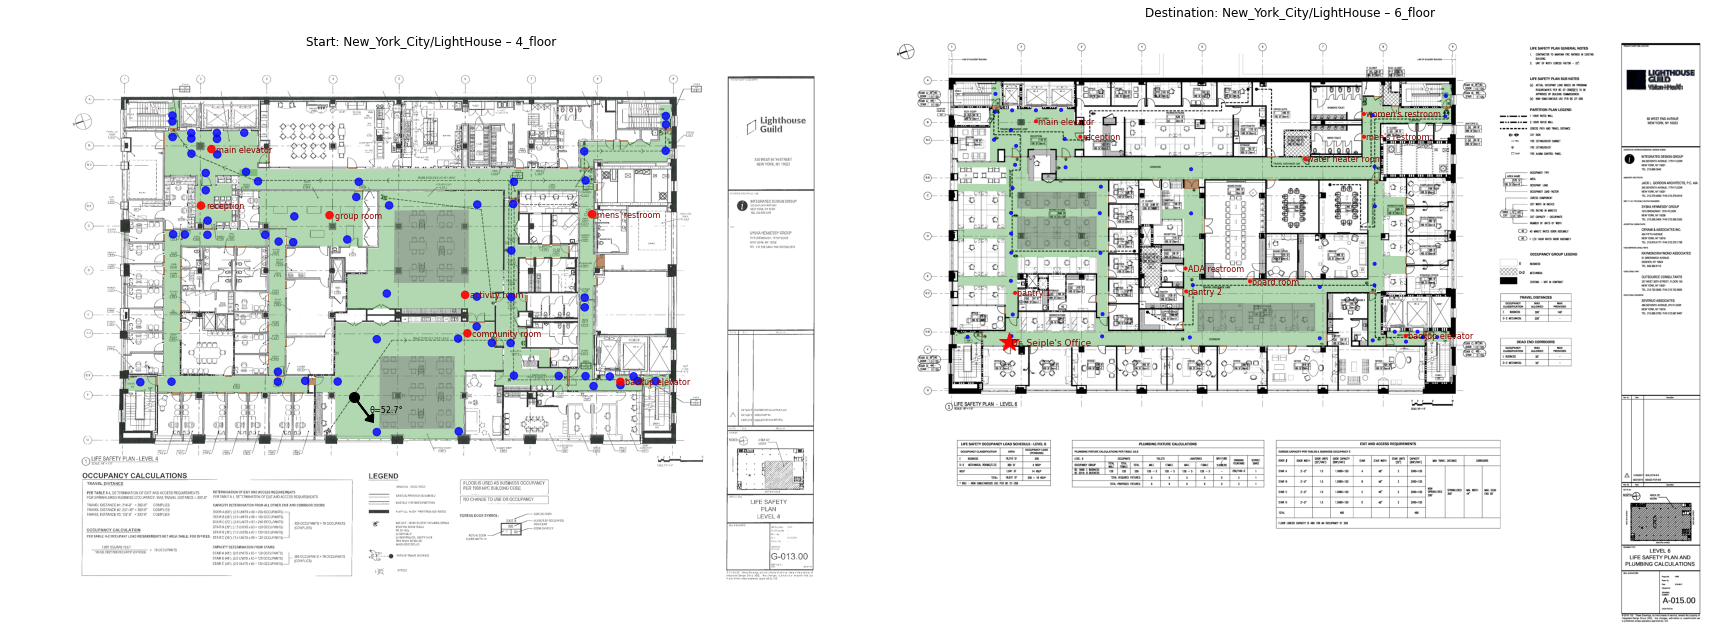

In [11]:
def get_floor_data(pf):
    """
    Extract all geometry and navigation data from a PathFinder.
    """
    walkable  = pf.walkable_polygons
    obstacle  = pf.obstacle_polygons
    doors     = [poly for poly, _ in pf.door_polygons]
    wps       = [(pf.nodes[n], pf.labels[n]) for n in pf.nav_ids]
    inter_wps = [
        (pf.nodes[n], pf.labels[n], "")
        for n in pf.nav_ids
        if 'stair' in pf.labels[n].lower() or 'elevator' in pf.labels[n].lower()
    ]
    dests     = [(pf.nodes[n], pf.labels[n]) for n in pf.dest_ids]
    return walkable, obstacle, doors, wps, inter_wps, dests

# Load background images for the floors
start_key = key
dest_key = (target_place, target_building, target_floor)
start_place, start_bld, start_flr = start_key
dest_place, dest_bld, dest_flr = dest_key

bg_start = mpimg.imread(os.path.join(DATA_FINAL_ROOT, start_place, start_bld, start_flr, "floorplan.png"))
bg_dest  = mpimg.imread(os.path.join(DATA_FINAL_ROOT, dest_place, dest_bld, dest_flr, "floorplan.png"))

pf_start = nav.pf_map[start_key]
pf_dest  = nav.pf_map[dest_key]

start_data = get_floor_data(pf_start)
dest_data  = get_floor_data(pf_dest)

# Visualization
if start_key == dest_key:
    fig, ax = plt.subplots(1, 1, figsize=(16, 14))
    axes = [ax]
else:
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24, 14))
    axes = [ax0, ax1]

ax = axes[0]
ax.imshow(bg_start, extent=[0, bg_start.shape[1], bg_start.shape[0], 0])
plot_floorplan(ax, *start_data[:3])

if start_key == dest_key:
    plot_points(ax, start_data[3], start_data[4], start_data[5], selected_dest=(selected_pt, selected_name))
else:
    plot_points(ax, start_data[3], start_data[4], start_data[5])

plot_pose(ax, x, y, theta)
ax.set_title(f"Start: {start_place}/{start_bld} – {start_flr}")
ax.axis("off")

if start_key != dest_key:
    ax = axes[1]
    ax.imshow(bg_dest, extent=[0, bg_dest.shape[1], bg_dest.shape[0], 0])
    plot_floorplan(ax, *dest_data[:3])
    plot_points(ax, dest_data[3], dest_data[4], dest_data[5], selected_dest=(selected_pt, selected_name))
    ax.set_title(f"Destination: {dest_place}/{dest_bld} – {dest_flr}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## 6. Plan and Visualize the Multi-Floor Navigation Path

Compute the shortest path between the start pose and selected destination (may involve multiple floors), handle errors, generate spoken-style navigation commands, and overlay the planned path on the corresponding floorplans.

📋 Navigation commands:
1. You are currently in dinner room 0 on 4_floor of LightHouse, New_York_City.
2. Sharp right to 5 o'clock
3. Forward 18 feet
4. Slight left to 11 o'clock
5. Forward 10 feet
6. Sharp right to 3 o'clock
7. Forward 49 feet and go through a door in 2 feet
8. Turn left to 10 o'clock
9. Forward 5 feet and go through a door in 4 feet
10. Slight left to 11 o'clock
11. Forward 20 feet
12. Turn right to 3 o'clock
13. Forward 16 feet and go through a door in 2 feet
14. Forward 21 feet and go through a door in 1 feet
15. You are approaching the elevator.
16. Press the up button to 6_floor of LightHouse using the elevator.
17. Slight right to 1 o'clock
18. Forward 83 feet and go through a door in 13 feet
19. Dr. Seiple's Office on 12 o'clock ahead

⏱️ Planning took 0.013 s


[INFO] Floor 4_floor segment length: 42.53 m
[INFO] Floor 6_floor segment length: 25.23 m


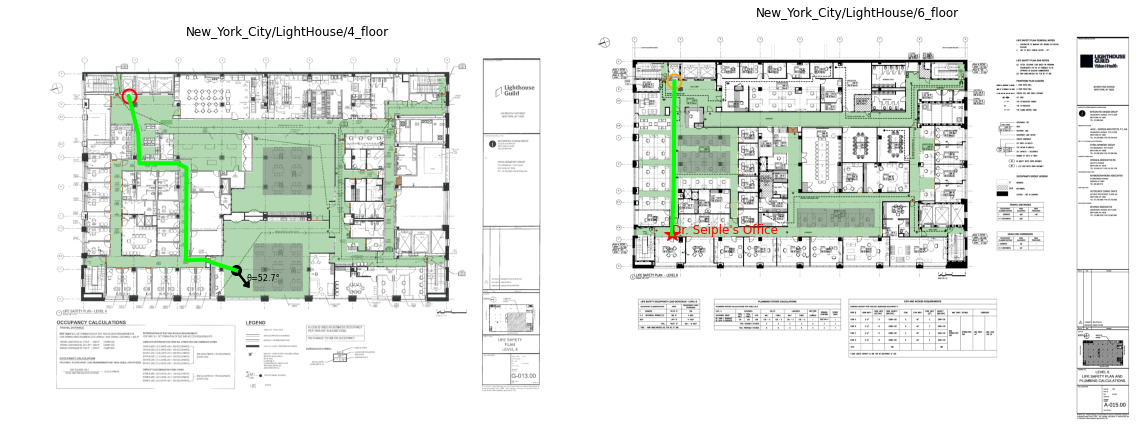

In [12]:
# 6.1 Look up destination ID for the selected destination
dest_id = pf_target.dest_ids[selected_index]

# 6.2 Parse start and destination keys
start_place, start_building, start_floor = key
dest_place, dest_building, dest_floor = target_key

start_xy = (x, y)

# 6.3 Compute shortest path (multi-floor support)
t0 = time.time()
result = nav.find_path(
    start_place, start_building, start_floor, start_xy,
    dest_place, dest_building, dest_floor, dest_id
)
t1 = time.time()

# 6.4 Generate navigation instructions or handle error
if 'error' in result:
    print("❌ Navigation failed:", result['error'])
else:
    cmds = commands_from_result(
        nav,
        result,
        initial_heading=-math.degrees(theta),
        unit="feet"
    )
    print("📋 Navigation commands:")
    for i, c in enumerate(cmds, 1):
        print(f"{i}. {c}")
    print(f"\n⏱️ Planning took {t1-t0:.3f} s")

# 6.5 Visualize the planned path overlayed on the floorplan(s)
plot_navigation_path(
    nav=nav,
    result=result,
    start_pose=(x, y, theta),
    data_root=DATA_FINAL_ROOT,
    start_place=start_place,
    start_building=start_building,
    start_floor=start_floor,
    dest_place=dest_place,
    dest_building=dest_building,
    dest_floor=dest_floor,
    selected_pt=selected_pt,
    selected_name=selected_name
)